In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
class TrafficEnv:
    def __init__(self, max_queue=10, max_steps=100, arrival_rate=0.3, pass_rate=1):
        self.max_queue = max_queue      # Maximum queue length (for state discretization)
        self.max_steps = max_steps      # Number of time steps per episode
        self.arrival_rate = arrival_rate  # Probability of vehicle arrival for each direction
        self.pass_rate = pass_rate      # Vehicles that can pass when green
        self.reset()

    def reset(self):
        # Reset queues and light state at the beginning of an episode
        self.queue_v = 0              # Vertical queue length
        self.queue_h = 0              # Horizontal queue length
        self.light = 0                # Start with vertical green (0) by default
        self.step_count = 0
        return (min(self.queue_v, self.max_queue),
                min(self.queue_h, self.max_queue),
                self.light)

    def step(self, action):
        # If action is switch, change the current light
        if action == 1:
            self.light = 1 - self.light

        # Random vehicle arrivals in each direction
        if np.random.rand() < self.arrival_rate:
            self.queue_v += 1
        if np.random.rand() < self.arrival_rate:
            self.queue_h += 1

        # Allow vehicles to pass from the green-light queue
        if self.light == 0:
            passed = min(self.pass_rate, self.queue_v)
            self.queue_v -= passed
        else:
            passed = min(self.pass_rate, self.queue_h)
            self.queue_h -= passed

        # Calculate reward (we want to minimize waiting vehicles)
        reward = - (self.queue_v + self.queue_h)

        self.step_count += 1
        done = self.step_count >= self.max_steps

        # Clip the queue lengths to max_queue for a discrete state representation
        next_state = (min(self.queue_v, self.max_queue),
                      min(self.queue_h, self.max_queue),
                      self.light)

        return next_state, reward, done, {}

In [3]:
max_queue = 10
env = TrafficEnv(max_queue=max_queue, max_steps=100, arrival_rate=0.3, pass_rate=1)


In [4]:
q_table = np.zeros((max_queue+1, max_queue+1, 2, 2))

In [5]:
# Hyperparameters for Q-learning
alpha = 0.1      # Learning rate
gamma = 0.95     # Discount factor
epsilon = 0.2    # Exploration rate
episodes = 500   # Total number of episodes for training

# To track total rewards per episode for visualization
episode_rewards = []

In [6]:
for ep in range(episodes):
    state = env.reset()
    total_reward = 0
    done = False

    while not done:
        # Use epsilon-greedy policy to choose an action
        if np.random.rand() < epsilon:
            action = np.random.choice([0, 1])
        else:
            action = np.argmax(q_table[state[0], state[1], state[2]])

        # Take the action and observe the new state and reward
        next_state, reward, done, _ = env.step(action)
        total_reward += reward

        # Q-learning update rule
        best_next = np.max(q_table[next_state[0], next_state[1], next_state[2]])
        q_table[state[0], state[1], state[2], action] = \
            (1 - alpha) * q_table[state[0], state[1], state[2], action] + \
            alpha * (reward + gamma * best_next)

        state = next_state

    episode_rewards.append(total_reward)

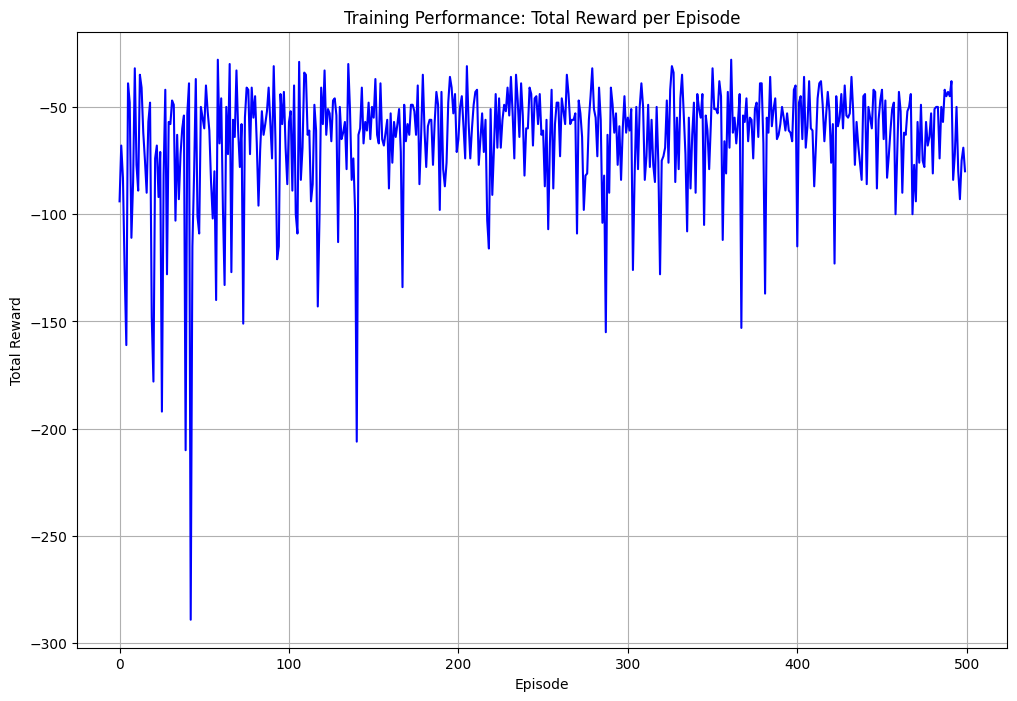

In [9]:
plt.figure(figsize=(12, 8))

# Plot 1: Total Reward per Episode

plt.plot(episode_rewards, color='blue')
plt.title('Training Performance: Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)

In [7]:
state = env.reset()
# Lists to store simulation history for visualization
states_over_time = [state]
queue_v_list = [state[0]]
queue_h_list = [state[1]]
light_list = [state[2]]

In [8]:
for _ in range(env.max_steps):
    # Use the learned policy (choose the best action)
    action = np.argmax(q_table[state[0], state[1], state[2]])
    next_state, reward, done, _ = env.step(action)
    state = next_state
    states_over_time.append(state)
    queue_v_list.append(state[0])
    queue_h_list.append(state[1])
    light_list.append(state[2])
    if done:
        break

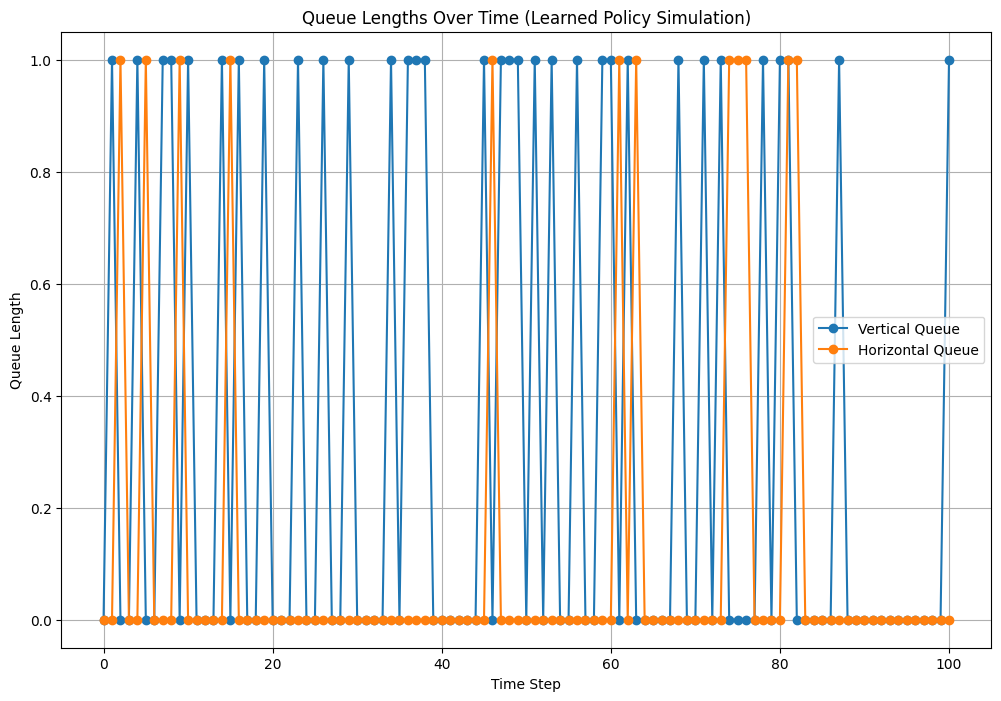

In [10]:
plt.figure(figsize=(12, 8))
plt.plot(queue_v_list, label='Vertical Queue', marker='o')
plt.plot(queue_h_list, label='Horizontal Queue', marker='o')
plt.title('Queue Lengths Over Time (Learned Policy Simulation)')
plt.xlabel('Time Step')
plt.ylabel('Queue Length')
plt.legend()
plt.grid(True)

plt.show()